<h1> ANALYSIS OF FUNDAMENTAL DATA USING ARIMA  </h1>

In [1]:
import sys
sys.path.append("../getData")
sys.path.append("../../visualization")
sys.path.append("../functions")
sys.path.append("../writer")
import matplotlib.pyplot as plt
from scipy.stats import norm
import itertools
import math
import transformations
import bdStocks
import graficosJupyterNotebook as graficos
import numpy as np
import pandas as pd
import transformationsDataframes
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from  statsmodels.tsa.stattools import arma_order_select_ic  as select_order
import scipy.stats
import statsmodels.stats.diagnostic
import statsmodels.api as sm
import math
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from scipy.stats import norm
import math
from datetime import timedelta
import numpy as np
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")
import configparser
config = configparser.ConfigParser()
config.read('../../config.properties')
log_dir_excepciones = "../../"+config.get('LOGS_DIR', 'excepciones')
import writer

<h2>Configurable options:</h2>

In [2]:
precios=True
columnas=["netIncome","totalRevenue","stock"]
columnasPrecios=["Adjusted_close","stock"]
tamMinimo=50
column="netIncome"
column2="Adjusted_close"
tam_train=0.8
periodicidad=4
nivel_confianza=0.1
max_lag=5
ponderaciones=[0.6,0.4]
transformar=False
periodoIndice="3M"
if precios:
    periodoIndice="M"
    periodicidad=12
    
    

In [3]:
def contrasteCorrelacionResiduos(serie,diferenciacion,nivel_confianza):
    T=len(serie)-diferenciacion
    varSerie=1/T
    desv=math.sqrt(varSerie)
    nivel=norm.ppf(1-nivel_confianza/2)
    a= abs(serie)/desv<nivel

    return a

class Modelo:
    def __init__(self,modelo,modeloExtendido,significacionP=None,significacionQ=None,significacionPEst=None,significacionQEst=None):
        self.modelo=modelo
        self.modeloExtendido=modeloExtendido
        self.errorTrain=modelo.mse
        self.errorTest=modeloExtendido.mse
        self.aicTrain=modelo.aic
        self.aicTest=modeloExtendido.aic
        self.aicTotal=ponderaciones[0]*self.aicTrain+ponderaciones[1]*self.aicTest
        self.errorTotal=ponderaciones[0]+self.errorTrain*ponderaciones[1]*self.errorTest
        self.significacionP=significacionP
        self.significacionQ=significacionQ
        self.significacionPEst=significacionPEst
        self.significacionQEst=significacionQEst
def crearYProbarModelo(serie_train,serie_test,ordenes=None,ordenesSeason=None,diferenciacion=0,diferenciacionSeason=0,periodo=periodicidad):
    modelo=None
    notSeasonalTrend="c"
    seasonalTrend="c"
    if diferenciacion>0:
        notSeasonalTrend="t"
    if diferenciacionSeason>0:
        seasonalTrend="t"
        if ordenesSeason is None:
            ordenesSeason=(0,0)
        
    if  ordenes is not None:
        ordenes=(ordenes[0],diferenciacion,ordenes[1])
    if  ordenes is not None and ordenesSeason is not None:
        ordenesSeason=(ordenesSeason[0],diferenciacionSeason,ordenesSeason[1],periodo)
    if ordenesSeason is not None:
           ordenesSeason=(ordenesSeason[0],diferenciacionSeason,ordenesSeason[1],periodo)
    if  ordenes is not None and ordenesSeason is not None:   
        s="c"
        if notSeasonalTrend=="t" or  seasonalTrend=="t":
            s="t"
       
        modelo=ARIMA(endog=serie_train,order=ordenes,seasonal_order=ordenesSeason)
    elif ordenes is not None:
        modelo=ARIMA(endog=serie_train,order=ordenes,trend=notSeasonalTrend)
    elif ordenesSeason is not None:
        modelo=ARIMA(endog=serie_train,seasonal_order=ordenesSeason,trend= seasonalTrend)
    if modelo is not None:    
        
        adj=modelo.fit()
        adj2=adj.extend(serie_test.to_numpy())
        
        return adj,adj2

Time: 03/22/2022, 21:36 Message: BD access time to get fundamental 0.4445827007293701

Time: 03/22/2022, 21:36 Message: Object size (fundamental data)0.127056 MB

Time: 03/22/2022, 21:36 Message: BD access time to get precios 0.19670486450195312

Time: 03/22/2022, 21:36 Message: Object size (precios data)0.888576 MB



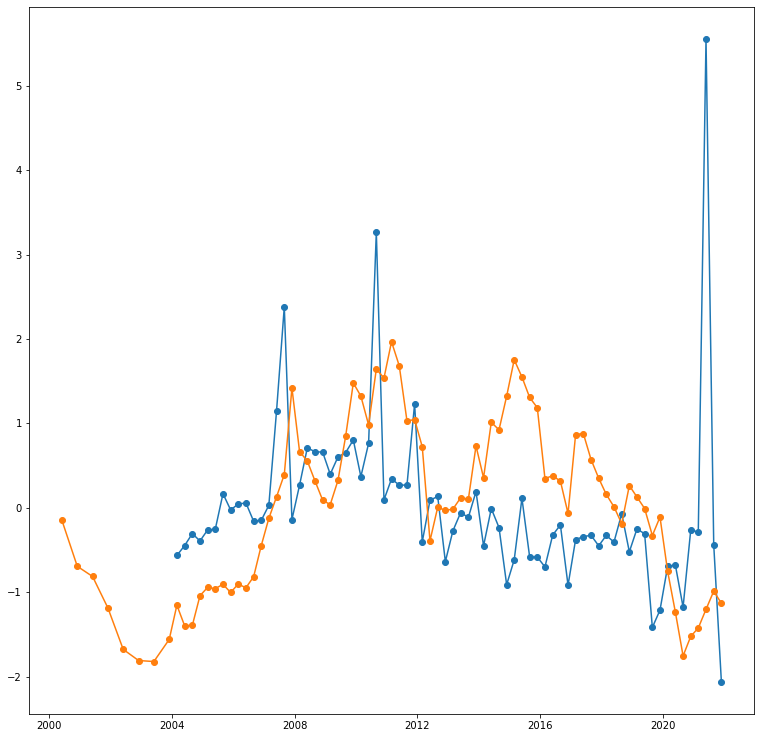

In [4]:
exchange="MC"
stock="TEF"
bd=bdStocks.getData()
data=bd.getDataByStock("fundamental",exchange,stock,bd=True,columnas=[column])
data2=bd.getDataByStock("precios",exchange,stock,bd=True,columnas=[column2])
data2= transformationsDataframes.pasarAMensual(data2)
data=transformationsDataframes.pasarAMensual(data)
data3=data.join(data2).fillna(method="ffill")
data3=(data3-data3.mean())/data3.std()
nas=0
nas+=int(data.isna().sum())
fig=plt.figure(figsize=(13,13))
plt.plot(data3.index,data3[column],label=column,marker="o")
plt.plot(data3.index,data3[column2],marker="o",label=column2)

In [5]:
if precios==True:
    data=data2
    column=column2
data.tail()

,Adjusted_close
fecha,
2021-11-01,3.6752
2021-12-01,3.8400
2022-01-01,3.8555
2022-02-01,4.0980
2022-03-01,4.2475


In [6]:

all_days = pd.date_range(data.index[0],\
                        data.index[-1],freq="3M",normalize=True)
all_days 
all_days=all_days.map(lambda x:x.replace(day=1))

a=data.index[-1]
b=data.iloc[-1]
data=data.reindex(all_days)
if a!=data.index[-1]:
    data.loc[a]=b
print(all_days)
print(data.tail())

DatetimeIndex(['1991-12-01', '1992-03-01', '1992-06-01', '1992-09-01',
               '1992-12-01', '1993-03-01', '1993-06-01', '1993-09-01',
               '1993-12-01', '1994-03-01',
               ...
               '2019-09-01', '2019-12-01', '2020-03-01', '2020-06-01',
               '2020-09-01', '2020-12-01', '2021-03-01', '2021-06-01',
               '2021-09-01', '2021-12-01'],
              dtype='datetime64[ns]', length=121, freq=None)
            Adjusted_close
2021-03-01          3.3628
2021-06-01          3.7224
2021-09-01          4.0738
2021-12-01          3.8400
2022-03-01          4.2475


a


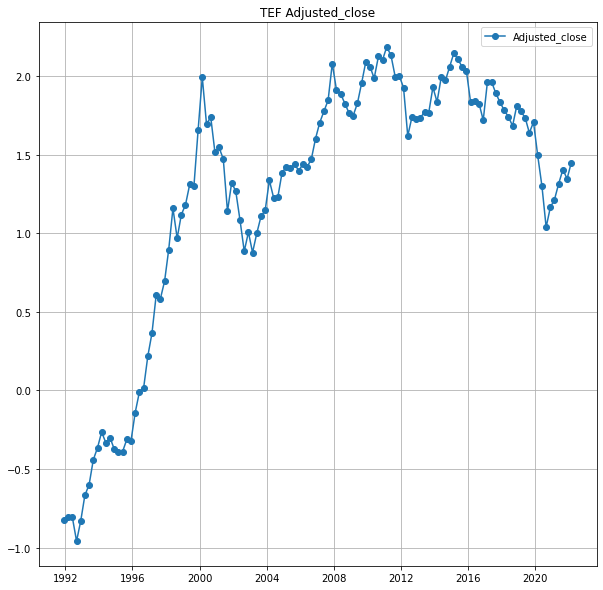

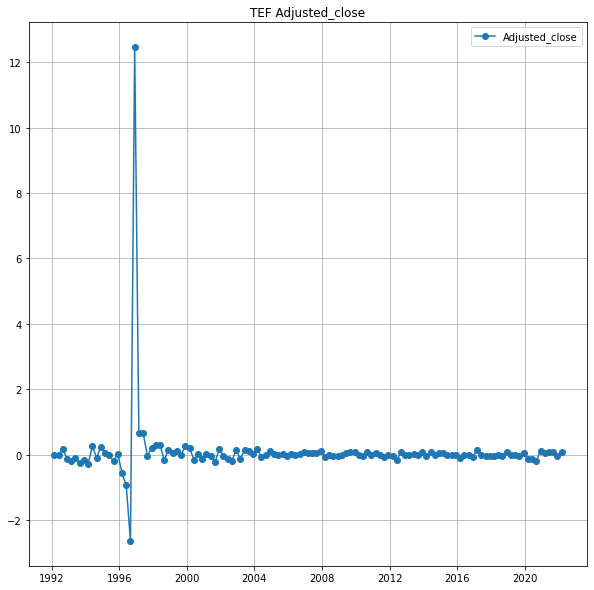

0.3832


DatetimeIndex(['1991-12-01', '1992-01-01', '1992-02-01', '1992-03-01',
               '1992-04-01', '1992-05-01', '1992-06-01', '1992-07-01',
               '1992-08-01', '1992-09-01',
               ...
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01',
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01'],
              dtype='datetime64[ns]', length=364, freq=None)

In [7]:
transformar=bool(input())
if transformar:
    minimo=np.min(data)[0]
    if minimo<0:
        print(minimo)
        data=data-minimo*2
    boxcox=transformations.boxcox
    data1=(data).applymap(lambda x:(boxcox(0,x)))
    graficos.linearplot(data1,stock+" "+column,False,column)
    graficos.linearplot(data1.transform(lambda x:x.pct_change()),stock+" "+column,False,column)
    print(minimo)
else:
    data1=data.copy()
data1=transformationsDataframes.pasarAMensual(data1)
all_days = pd.date_range(data1.index[0], data1.index[-1]+timedelta(days=40),freq=periodoIndice,normalize=True)
all_days=all_days.map(lambda x:x.replace(day=1))
nas+=len(all_days)-len(data1.index)
data1=data1.reindex(all_days)
serie=data1[column].fillna(method="ffill").dropna()
tam=len(serie)
lim_train=int(tam*tam_train)
serie_train=serie[:lim_train]
serie_test=serie[lim_train:]
all_days

In [13]:
(nas,len(serie))

(17, 72)

In [10]:

adf=adfuller(serie_train)
adf
posibleEstacionaridad=False
diferenciacion=0
diferenciacionEstacional=0
if adf[1]>nivel_confianza:
    posibleEstacionaridad=True

if posibleEstacionaridad and estacional:
    serie1=pd.Series(serie_train).diff(periodicidad).dropna()
    adf1=adfuller(serie1)
if posibleEstacionaridad:
    serie2=pd.Series(serie_train).diff(1).dropna()
    adf2=adfuller(serie2)

if posibleEstacionaridad and estacional:
    print(adf1,adf2)
    niveles=[0.0001,0.001,0.01,0.05,0.01]
    for idx,nivel in enumerate(niveles[1:]):
        if adf1[1]<nivel:
            diferenciacionEstacional=1
            break
        elif adf2[1]<niveles[idx]:
            diferenciacion=1
            break
    if diferenciacion==0 and diferenciacionEstacional==0:
            serie3=pd.Series(serie1).diff(1).dropna()
            adf3=adfuller(serie3)

            if adf3[0]<adf3[4]["5%"]:
                diferenciacionEstacional=1
                diferenciacion=1
            else:
                serie_train=None
print(diferenciacion, diferenciacionEstacional)   

(-2.7089270419091718, 0.07250619924136865, 12, 266, {'1%': -3.455175292841607, '5%': -2.8724677563219485, '10%': -2.57259315846006}, -523.6591976366235) (-4.36305377198323, 0.0003448573958575998, 8, 281, {'1%': -3.4538376962008495, '5%': -2.8718811911083093, '10%': -2.5722803076202174}, -630.1230147498351)
1 0


In [11]:
#ver si hay que diferenciar la serie
#en adfuller la nula es que hay raiz unitaria
diferenciacion=0
diferenciacionEstacional=0
estacional=True
paramFuller=5
#adf=adfuller(serie_train.dropna())
adf=adfuller(serie_train.diff(1).dropna())
#adf=adfuller(serie_train.diff(periodicidad).dropna())
adf


(-4.36305377198323,
 0.0003448573958575998,
 8,
 281,
 {'1%': -3.4538376962008495,
  '5%': -2.8718811911083093,
  '10%': -2.5722803076202174},
 -630.1230147498351)

In [13]:
diferenciacion=1

hay diferenciacion
289
0.058823529411764705
[ True False False False False False  True False False  True False False
  True False False False False False  True False False  True False False
  True False False False False False  True False False  True False False
 False False False False False False False False False  True False False
 False False False False False False  True False False  True False False
 False False False  True False False False False False False False False
  True False False  True False False  True False False False False False
 False False False False False False  True False False  True False False
 False] [ True False False False False False  True False False  True False False
 False False False False False False  True False False  True False False
  True False False  True False False  True False False  True False False
  True False False  True False False False False False  True False False
  True False False False False False  True False False  True False False

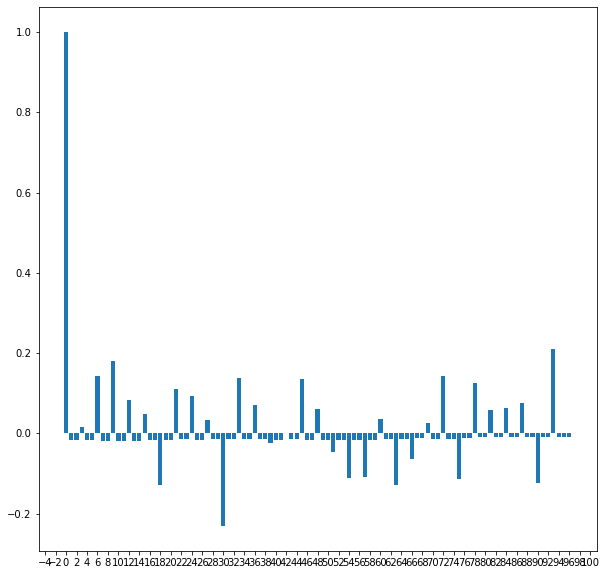

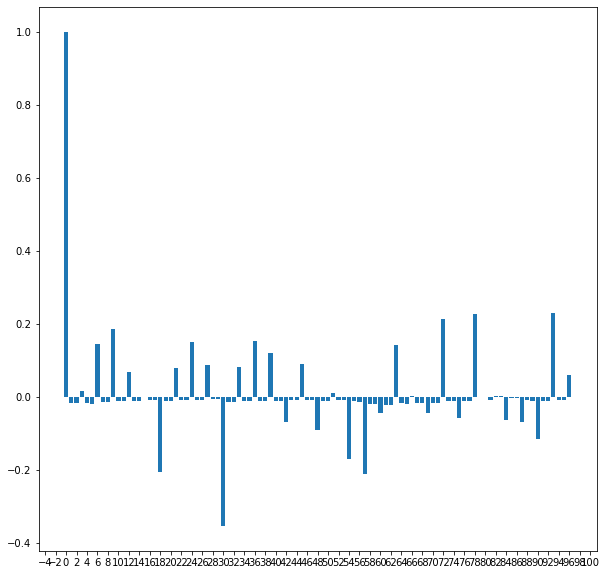

In [14]:
import scipy.stats
import statsmodels.stats.diagnostic
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
serie1=serie_train.copy()
if diferenciacion and  diferenciacionEstacional:
    serie1=serie_train.diff(periodicidad).diff(1)
elif diferenciacion:
    print("hay diferenciacion")
    serie1=serie_train.diff(1)
elif diferenciacionEstacional:
    serie1=serie_train.diff(periodicidad)
serie1=serie1.dropna() 
corr=acf(serie1,nlags=int(len(serie1)/3))
pcorr=pacf(serie1,nlags=int(len(serie1)/3))
nivel=norm.ppf(0.90)
def devolverEstadisticos(corr,pcorr,diferenciacion,serie):
    T=len(serie)-diferenciacion
    print(T)
    varSerie=1/T
    desv=math.sqrt(varSerie)
    print(desv)
    return abs(corr)/desv,abs(pcorr)/desv
estCorr,estPcorr=(devolverEstadisticos(corr,pcorr,diferenciacion,serie1))
print(estCorr>nivel,estPcorr>nivel)
print(nivel)
graficos.correlograma(corr,pcorr)

In [15]:
orden=(1,1,0)
ordenEst=None
adj,adj2=crearYProbarModelo(serie_train,serie_test,ordenes=orden,\
        ordenesSeason=ordenEst,diferenciacion=diferenciacion,diferenciacionSeason=diferenciacionEstacional)

if ordenEst is None:
    ordenEst=(0,0,0)
modelo=Modelo(adj,adj2, orden[0],orden[2],ordenEst[0],ordenEst[2])
print(adj.params)

x1        0.009835
ar.L1     0.040133
ma.L1    -0.058336
sigma2    0.005650
dtype: float64


In [39]:
print(adj.mse,adj2.mse)
print(adj.aic)


0.008014977293729837 0.0051885256826178
-670.0492981562707


-471.215763027275 x1        0.009835
ar.L1     0.040133
ma.L1    -0.058336
sigma2    0.005650
dtype: float64 {'seasonal_periods': 0, 'measurement_error': False, 'time_varying_regression': False, 'simple_differencing': False, 'enforce_stationarity': True, 'enforce_invertibility': True, 'hamilton_representation': False, 'concentrate_scale': False, 'trend_offset': 1, 'order': (1, 1, 1), 'seasonal_order': (0, 0, 0, 0), 'k_diff': 1, 'k_seasonal_diff': 0, 'k_ar': 1, 'k_ma': 1, 'k_seasonal_ar': 0, 'k_seasonal_ma': 0, 'k_ar_params': 1, 'k_ma_params': 1, 'trend': 't', 'k_trend': 1, 'k_exog': 0, 'mle_regression': True, 'state_regression': False} 0.008014977293729837
0.006872565015617762
0.9965637174921911
2.1649626325980895e-121
[0.99 0.96 0.99 0.99 1.   0.38 0.49 0.59 0.06 0.09]


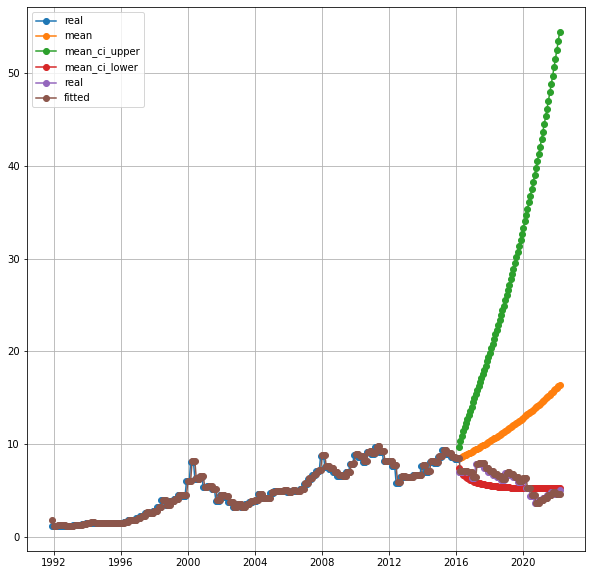

In [16]:

import matplotlib.pyplot as plt
if transformar:
    serie_train1=serie_train.map(lambda x:(math.exp(x)+2*minimo))
    serie_test1=serie_test.map(lambda x:(math.exp(x)+2*minimo))
else:
    serie_train1=serie_train
    serie_test1=serie_test
print(modelo.aicTotal,modelo.modelo.params,modelo.modelo.specification,modelo.modelo.mse)
print(modelo.modelo.test_heteroskedasticity("breakvar",alternative= "two-sided")[0][1])
print(modelo.modelo.test_heteroskedasticity("breakvar",alternative= "increasing")[0][1])
print(modelo.modelo.test_normality(method="jarquebera")[0][1])
u=(modelo.modelo.test_serial_correlation(method="ljungbox"))[0][1]
print(np.around(u,decimals=2))
dataframePred=modelo.modelo.get_forecast(len(serie_test1)).summary_frame()
if transformar:
    dataframePred=dataframePred.applymap(lambda x:(math.exp(x)+2*minimo))
dataframePred["real"]= serie_test1  
primero=modelo.modelo.fittedvalues
segundo=modelo.modeloExtendido.fittedvalues
if transformar:
         primero=primero.map(lambda x:(math.exp(x)+2*minimo))
         segundo=segundo.map(lambda x:(math.exp(x)+2*minimo))

graficos.plot_forecast(serie_train1,dataframePred,pd.concat([primero,segundo]))